# Machine Learning Assignment

#### **Course**: Machine Learning
- **Teaching Staff**
 - Alípio Jorge
 - Inês Dutra

**Assignment nº 1**
- **Group B**:
 - Ana Raquel Maceiras (200604342) 
 - Hélder Vieira (up201503395)
 - Miguel Tavares (up200902937)
 - Rui Vieira (201403035)         

## Introdução

Classification problems...

For artificial data sets, as the original distributions from which the data was generated are known, the exact Bayes Decision Boundary can be calculated and visualized. However, in real life classification problems, the Bayes Decision Boundary is not known. Thus, Machine Learning algorithms try to find the closest Decision Boundary to the Bayes Decision Boundary that in turn allows to divide 



<br>
<br>
<br>
<br>
up the feature space such that labels are assigned correctly to points in the feature space, or at least, as correctly as is possible. 
The Decision Boundary separates the data-points into regions, which are actually the classes in which they belong.
 
Different methods produce models with different degrees of expressivity (the variety of functions emulated) and some methods have hyperparameters that increase or reduce the expressivity of the models. More expressive models often incur in overfitting, which is related to the bias-variance trade-off. The aim of this first assignment is to perform a short study on the behavior of methods with respect to their ability of approximating the Bayes Decision Boundary and where they stand in the bias-variance tradeoff.

Total error | Bias-Variance trade off | Overfitting | model complexity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score
from scipy import stats

In [2]:
names = ['Sequence name','mcg','gvh','alm','mit','erl','pox','vac','nuc','class'];
data_yeast = pd.read_csv('yeast.data', header = None, sep = '\s+', names = names);
data_pima = pd.read_csv('diabetes.csv');

## Question 1

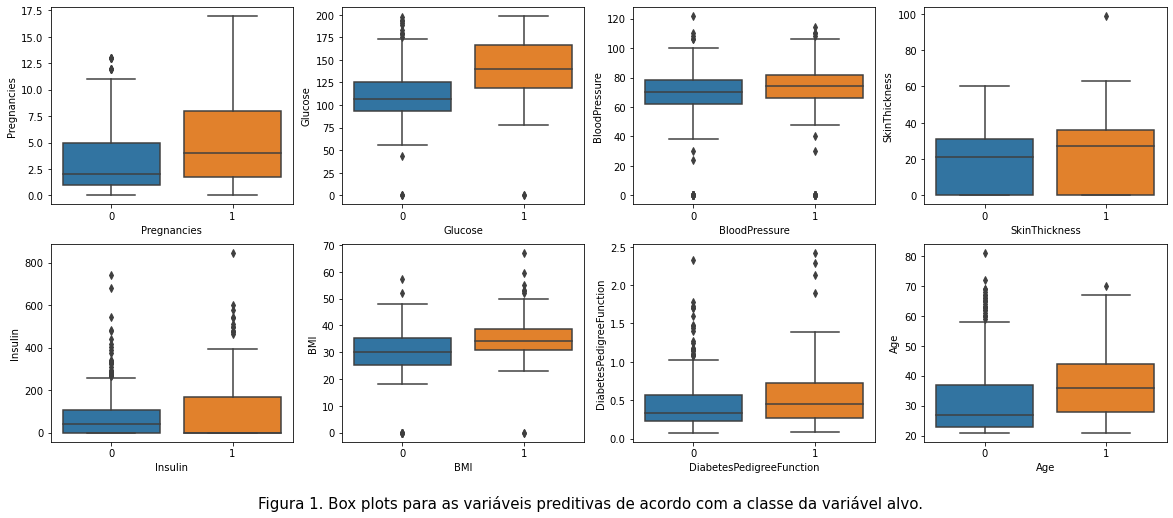

In [3]:
cols = data_pima.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 8))
txt="Figura 1. Box plots para as variáveis preditivas de acordo com a classe da variável alvo."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=data_pima)
    ax[i//4, i%4].set(xlabel=cols[i])
plt.show();

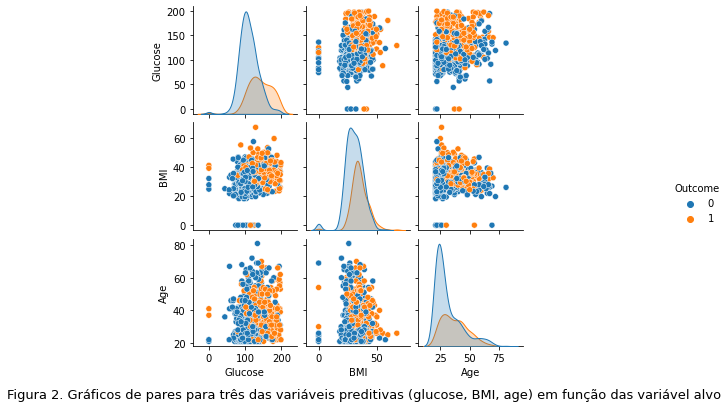

In [4]:
data_pima_sel = data_pima.drop(columns = ['BloodPressure', 'SkinThickness', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin'])
sns.pairplot(data_pima_sel, hue = 'Outcome', size=1.8)
txt="Figura 2. Gráficos de pares para três das variáveis preditivas (glucose, BMI, age) em função das variável alvo"
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=13)
plt.show();

<p>Após análise aos gráficos apresentados, podemos observar rapidamente que as variáveis que melhor "separam" a variável alvo são $Glucose$, $BMI$ e $Age$. Contudo, as duas escolhidas (como requisitado pelo exercicio) foram a $Glucose$ e $BMI$. A variável $Age$ foi descartada pois tinha mais outliers.

## Methods comparison (kNN, Logistic Regression, QDA)

#### Normalization
<p>Após a escolha das duas variáveis preditivas, foram removidos alguns dados pois os mesmos representavam situação não reais (p.e. valores de glucose nulos). Para além disso, uma vez que um dos modelos depende do cálculo de distâncias (kNN), procedeu-se à normalização dos valores para as variáveis $Glucose$ e $BMI$.

In [5]:
data_pima_clean = data_pima_sel[(data_pima['Glucose'] != 0) & (data_pima['BMI'] != 0)]
data_pima_clean = data_pima_clean.sample(frac=1).reset_index(drop=True)

In [6]:
data_pima_sel_final = data_pima_clean.drop(columns = 'Age')
column_names = ['Glucose', 'BMI']
temp = data_pima_sel_final[column_names].values
temp_scaled = MinMaxScaler().fit_transform(temp)
data_pima_sel_final[column_names] = temp_scaled

#### Separation in train data and test data

In [7]:
X = data_pima_sel_final.drop(columns = 'Outcome').values
y = data_pima_sel_final.loc[:,'Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify= y)

In [8]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

In [9]:
def StratKF(model, splits,x_train, y_train, x_test, y_test): #fitted model necessary
    SKF = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
    score = []
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    for train_index, test_index in SKF.split(x_test, y_test):
        x_test1 = x_train[test_index]
        y_test1 = y_train[test_index]
        score.append(f1_score(y_test1, model.predict(x_test1)))
    print(f'F1 score on {splits}-fold test data: ',round(np.mean(score),4),'+/-', round(np.std(score),4))
    print('F1 score on training set: ',round(f1_score(y_train, y_pred_train),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test), 4))

### Logistic Regression

In [10]:
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
StratKF(modelLogReg,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.5709 +/- 0.2229
F1 score on training set:  0.6062 
F1 score on test set:  0.5227


### Quadratic Discriminant Analysis

In [11]:
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
StratKF(modelQDA,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.6132 +/- 0.2374
F1 score on training set:  0.6216 
F1 score on test set:  0.5435


### kNN

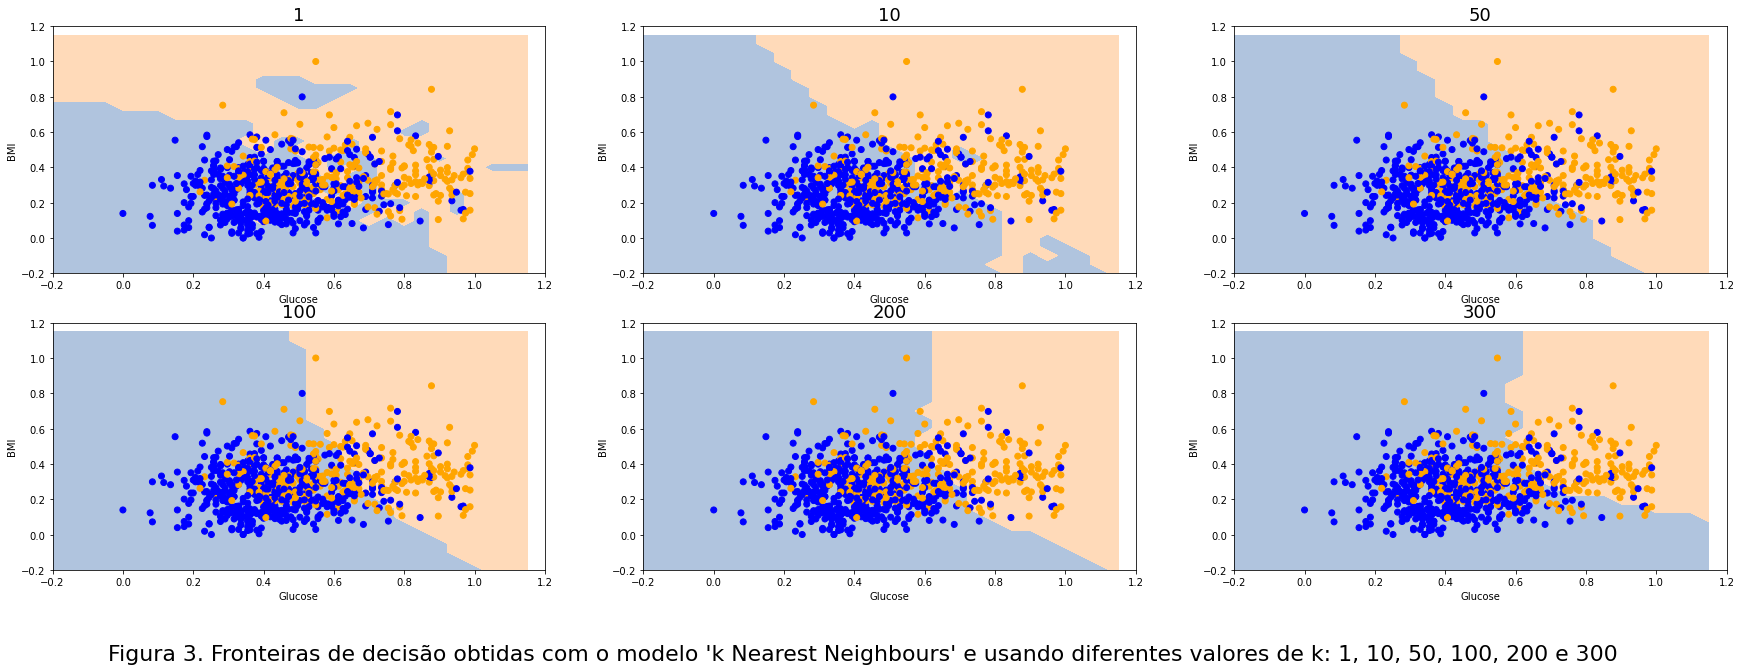

In [12]:
fig = plt.figure(figsize=(30,10))
k = [1,10,50,100,200,300]
for i in range(len(k)):
    modelkNN = kNN(n_neighbors=k[i])
    modelkNN.fit(x_train, y_train)
    ax = fig.add_subplot(2, 3, i+1)
    plot_classifier_boundary(modelkNN, X)
    ax.scatter(X[:,0],X[:,1],color=cmap(y))
    ax.set_title(k[i], fontsize = 18)
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BMI')
txt="Figura 3. Fronteiras de decisão obtidas com o modelo 'k Nearest Neighbours' e usando diferentes valores de k: 1, 10, 50, 100, 200 e 300"
plt.figtext(0.5, 0, txt, wrap=True, horizontalalignment='center', fontsize=22)
plt.show;

Como esperado, e anteriormente referenciado, à medida que o k aumenta, a complexidade do modelo diminui. Observado a figura 3 podemos concluir que a fronteira de decisão vai se tornando mais simples.

In [13]:
def valid_curve(model, x_train, y_train, n_jobs, scoring, param_range = np.array([*range(1,301)]), param_name="n_neighbors"):
    np.random.seed(1)
    train_scores, test_scores = validation_curve(model, x_train, y_train, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8, 4))
    plt.title("kNN Validation Curve")
    plt.xlabel("k Neighbors")
    plt.ylabel("Score")
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
    plt.legend(loc="best")
    print("Best K is %d" %param_range[np.where(test_scores_mean == max(test_scores_mean))][0])
    return param_range[np.where(test_scores_mean == max(test_scores_mean))][0]

Best K is 53


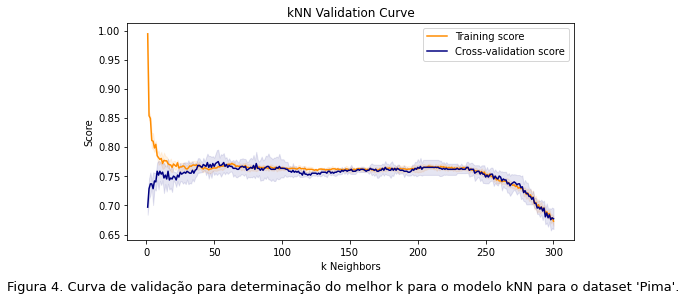

In [14]:
modelkNN = kNN()
k_best = valid_curve(modelkNN, x_train, y_train, 6, 'accuracy')
txt="Figura 4. Curva de validação para determinação do melhor k para o modelo kNN para o dataset 'Pima'."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=13)
plt.show();

Como se pode visualizar na figura da fronteira de classificação e na curva de validação, inicialmente (aprox. até k igual 5) ocorre overfitting, seguidamente com o aumento do k existe uma tendência de estabilização da fronteira sendo que os scores de treino e CV são similares até um k de aproximadamente 250 em que começa a ocorrer underfitting. O k escolhido como ideal corresponde ao maximizante do score da CV.

In [15]:
modelkNN = kNN(n_neighbors=k_best)
modelkNN.fit(x_train, y_train)
StratKF(modelkNN,5, x_train, y_train, x_test, y_test)

F1 score on 5-fold test data:  0.5856 +/- 0.2236
F1 score on training set:  0.605 
F1 score on test set:  0.5169


In [16]:
#ROC AUC
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('kNN ROC AUC=%.3f' % (kNN_auc))

LR ROC AUC=0.778
QDA ROC AUC=0.770
kNN ROC AUC=0.774


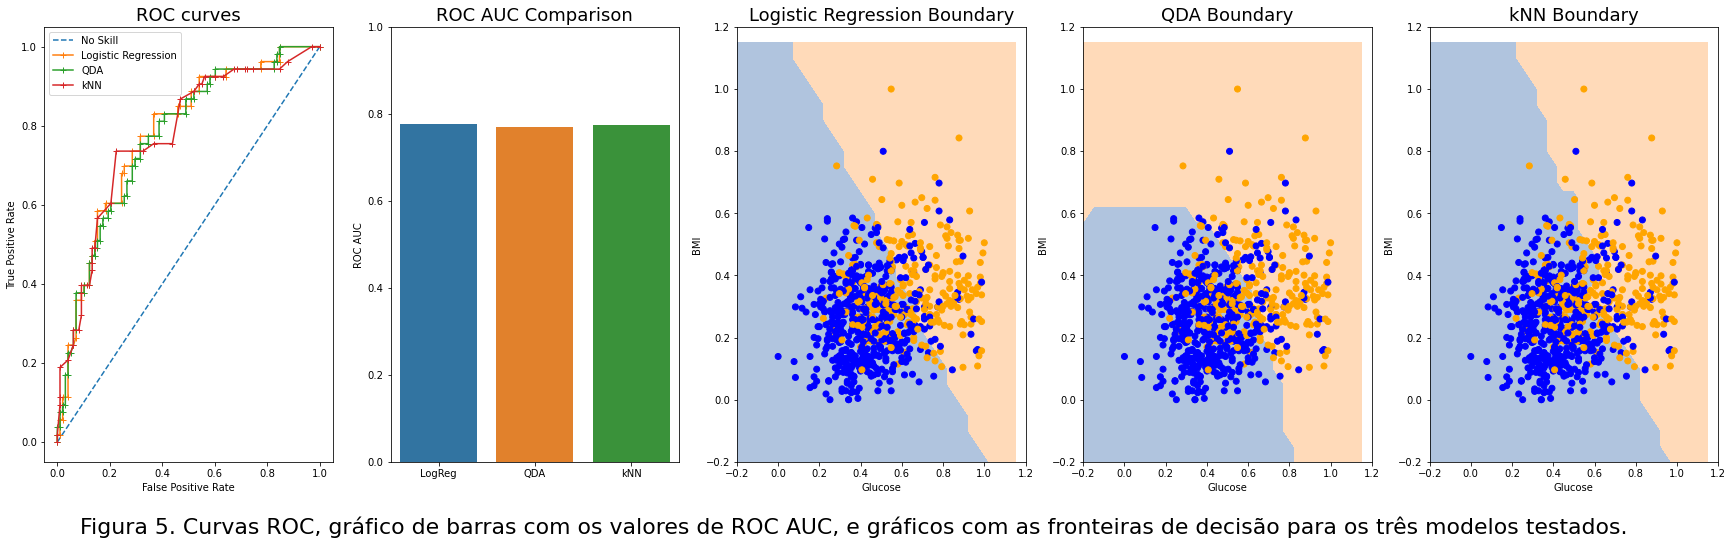

In [17]:
#ROC curves
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)
figs = plt.figure(figsize=(30,8))
# plot the roc curves
axs = figs.add_subplot(1, 5, 1)
axs.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
axs.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
axs.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC curves', fontsize = 18)
axs.legend();
##Barplot of AUCs
axs = figs.add_subplot(1, 5, 2)
sns.barplot(y=[LogReg_auc,QDA_auc,kNN_auc], x=['LogReg', 'QDA', 'kNN'], ax=axs)
axs.set_ylim(0,1)
axs.set_title('ROC AUC Comparison', fontsize = 18)
axs.set_ylabel('ROC AUC');
model_list = [(modelLogReg,'Logistic Regression Boundary') , (modelQDA, 'QDA Boundary'), (modelkNN, 'kNN Boundary')]
for i in range(3,6,1):
    axs = figs.add_subplot(1, 5, i)
    plot_classifier_boundary(model_list[i-3][0],X)
    axs.scatter(X[:,0],X[:,1],color=cmap(y))
    axs.set_xlabel('Glucose')
    axs.set_ylabel('BMI');
    axs.set_title(model_list[i-3][1], fontsize = 18)
txt="Figura 5. Curvas ROC, gráfico de barras com os valores de ROC AUC, e gráficos com as fronteiras de decisão para os três modelos testados."
plt.figtext(0.5, 0, txt, wrap=True, horizontalalignment='center', fontsize=22)
plt.show();

<p>Nesta análise comparámos os três modelos directamente (o kNN foi alvo de ajuste de hiperparâmetros, recorrendo à análise do gráfico acima representado). Podemos observar que ambos os modelos obtêm um valor de AUC semelhante, a rondar os 75%.<br>
Observando as "linhas de fronteira" obtidas rapidamente podemos observar a semelhança entre a regressão logistica e o kNN, o que seria de esperar dado o valor elevado do k, bem como o valor quase idêntico do AUC. É importante também referir, que dado o dataset escolhido o qual contêm uma boa separação das classes, um modelo como a regressão logistica (pouco flexível), consegue apresentar um resultado quase idêntico ao modelo utilizado mais flexível, o kNN. Isto é consequência de o valor óptimo de k ser bastante elevado, o que leva a uma fronteira de decisão bastante linear. 
Relativamente à QDA, a fronteira obtida não se assemelha a uma linearização, mas sim a uma quadratização da linha. Não é um modelo tão flexível como o kNN, mas em alguns casos é possível que tenha um melhor comportamento devido à abordagem quadrática.

## Question 2

#### Normalization

In [18]:
MinMaxSca = MinMaxScaler()
data_yeast[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']] = MinMaxSca.fit_transform(data_yeast.loc[:,['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])

#### Separation in train data and test data

In [19]:
X = data_yeast.loc[:, ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']].values
Y = data_yeast.loc[:,'class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y, shuffle=True)
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [20]:
def StratKFW(model, splits, X_train, Y_train, X_test, Y_test):
    Y_pred_trainLogReg = model.predict(X_train)
    Y_pred_testLogReg = model.predict(X_test)
    print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
        '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))
    f1score = []
    accscore = []
    for train_index, test_index in SKF.split (X_test, Y_test):
        X_test1 = X_test[test_index]
        Y_test1 = Y_test[test_index]
        f1score.append(f1_score(Y_test1, model.predict(X_test1), average='weighted'))
        accscore.append(accuracy_score(Y_test1, model.predict(X_test1)))
    print(f'Weighted F1 score on {splits}-fold test data: ',round(np.mean(f1score_LogReg),4),'+/-', round(np.std(f1score_LogReg),4))
    print('\nClassification report:\n',classification_report(Y_test, Y_pred_testLogReg, digits=3))
    return f1score, accscore

### Logistic regression

In [21]:
modelLR = LogReg()
modelLR.fit(X_train, Y_train)
f1score_LogReg, accscore_LogReg = [], []
f1score_LogReg, accscore_LogReg = StratKFW(modelLR, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  nan +/- nan

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



### kNN

Best K is 17


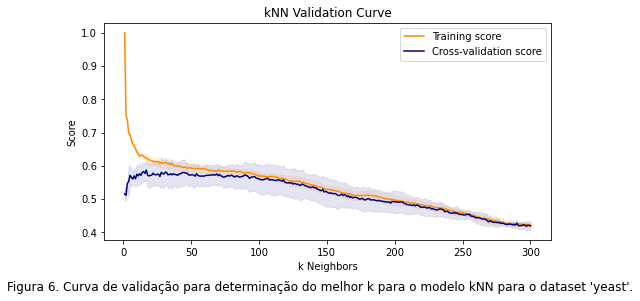

In [22]:
k_best = valid_curve(modelkNN, X_train, Y_train, 6, 'accuracy')
txt="Figura 6. Curva de validação para determinação do melhor k para o modelo kNN para o dataset 'yeast'."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show();

In [23]:
modelknn = kNN(n_neighbors=k_best)
modelknn.fit(X_train, Y_train)
f1score_knn, accscore_knn = [], []
f1score_knn, accscore_knn = StratKFW(modelknn, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.6207 
Weighted F1 score on test set:  0.5658
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.526     0.656     0.584        93
         ERL      0.000     0.000     0.000         1
         EXC      0.667     0.571     0.615         7
         ME1      0.462     0.667     0.545         9
         ME2      0.333     0.200     0.250        10
         ME3      0.719     0.719     0.719        32
         MIT      0.681     0.653     0.667        49
         NUC      0.554     0.477     0.513        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.576       297
   macro avg      0.461     0.444     0.446       297
weighted avg      0.565     0.576     0.566       297



### Decision tree

In [ ]:
modeltree = DTreeClass()
modeltree.fit(X_train, Y_train)

In [25]:
def model_grid_search(model, param_grid, cv, scoring, n_jobs): # "cv - integer, to specify the number of folds in a `(Stratified) KFold`,"
    model_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, refit = True, scoring= scoring, n_jobs = n_jobs)
    model_grid.fit(X_train, Y_train)
    print(f"Best estimator: {model_grid.best_estimator_} \n  Best score: {model_grid.best_score_} \n Best Params: {model_grid.best_params_}")
    return model_grid.best_estimator_

In [26]:
max_depth = [None] + [x for x in np.arange(1,20,4)]
min_sample_split= np.arange(2, 10,2)
min_sample_leaf = np.arange(1,5)
ccp_alpha = np.arange(0.01,100, 10)
param_grid_tree = {"criterion": ['gini', "entropy"],\
              "splitter": ['best',"random"],\
              "max_depth": max_depth,\
              "min_samples_split": min_sample_split,\
              "min_samples_leaf": min_sample_leaf, \
              "ccp_alpha": ccp_alpha}

In [27]:
tree_grid = model_grid_search(modeltree, param_grid_tree, 5, "f1_weighted", 2) 

Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       min_samples_leaf=4, min_samples_split=4) 
  Best score: 0.5669393207369835 
 Best Params: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}


In [28]:
modeltree = tree_grid
f1score_tree, accscore_tree = StratKFW(modelLR, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



### Achieved results comparison

In [29]:
stats_f1,pvalue_f1 = stats.f_oneway(f1score_LogReg, f1score_knn, f1score_tree)
stats_acc, pvalue_acc = stats.f_oneway(accscore_LogReg, accscore_knn, accscore_tree)

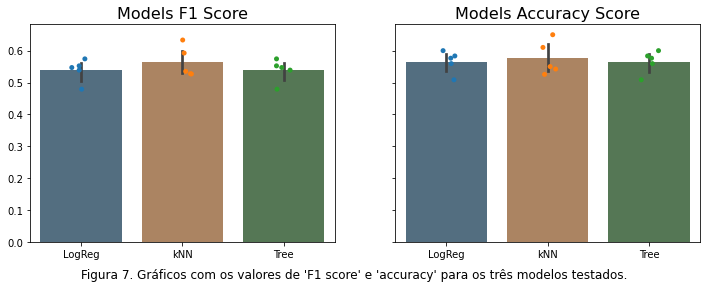

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
#sns.set_theme(style="whitegrid")
ax[0].set_title('Models F1 Score', fontsize = 16)
ax[1].set_title('Models Accuracy Score', fontsize = 16)
sns.stripplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[0])
sns.barplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, saturation=0.3, ax=ax[0])
sns.stripplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[1])
sns.barplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, saturation=0.3, ax=ax[1]);
txt="Figura 7. Gráficos com os valores de 'F1 score' e 'accuracy' para os três modelos testados."
plt.figtext(0.5, 0, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show();

Nesta questão foi nos proposto comparar como 3 modelos se comportavam com um dataset com várias classes alvo com uma representatividade reduzida (small classes). Um dos maiores problemas devido ao problema anteriormente referido foi os modelos não serem capazes de detectar algumas dessas classes.
No modelo kNN foi realizada uma optimização do valor de k, e nas árvores de decisão, um grid search. No entanto, nenhum dos modelos conseguiu destacar-se dos restantes, obtendo-se resultados similares. 

## Conclusão

Dos resultados apresentados é possível concluir que os diversos modelos utilizados tem comportamentos distintos. No entanto, mesmo alguns sendo alvo de optimizações, verifica-se que a sua performance está muito dependente dos dados fornecidos.
Podiam ter sido abordados outros modelos de diferentes características e respectivas suposições mais adequados aos dados fornecidos, tais como as random forest que tiram partido do bagging, o qual provavelmente detectaria também as classes menos representadas. 

## Referências

Towards Data Science <br>
The Elementals of Statistical Learning <br>
Pattern Recognition and Machine Learning <br>

